# Libraries

In [53]:
from fastbook import *

In [54]:
from fastai.vision.widgets import *

# Download dataset

Bing API key

In [111]:
key = os.environ.get('AZURE_SEARCH_KEY', '6984586093114464a39823bf7f7e25ce')

Designate searches and directory to be stored

In [112]:
company_name = 'nestle logo','unilever logo','nike logo', 'adidas logo', 'coca cola logo'
path = Path(r'logos')

Create a 'bear' folder and subfolders with the respective searched string. Download and organize searched images accordingly 

In [113]:
if not path.exists():
    path.mkdir()
    for company in company_name:
        dest = (path/company)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{company} logo', max_images=150)
        download_images(dest, urls=results.attrgot('contentUrl'))

check if the folder contains the files (if yes, the code above ran successfully) 

# Data cleanup 

In [60]:
fns = get_image_files(path)
fns

(#556) [Path('logos/adidas logo/00000000.png'),Path('logos/adidas logo/00000001.jpg'),Path('logos/adidas logo/00000002.jpg'),Path('logos/adidas logo/00000003.jpg'),Path('logos/adidas logo/00000004.png'),Path('logos/adidas logo/00000005.png'),Path('logos/adidas logo/00000006.gif'),Path('logos/adidas logo/00000007.jpg'),Path('logos/adidas logo/00000008.jpg'),Path('logos/adidas logo/00000009.jpg')...]

check and display failed/corrupted files

In [61]:
failed = verify_images(fns)
failed

(#9) [Path('logos/adidas logo/00000064.png'),Path('logos/nestle logo/00000095.png'),Path('logos/nestle logo/00000099.jpg'),Path('logos/nike logo/00000088.jpg'),Path('logos/nike logo/00000108.jpg'),Path('logos/nike logo/00000126.jpg'),Path('logos/unilever logo/00000088.jpg'),Path('logos/unilever logo/00000094.jpg'),Path('logos/unilever logo/00000096.jpg')]

remove corrupted files

In [62]:
failed.map(Path.unlink);

In [105]:
# convert all png files in path into jpg

path = Path(r'C:\Users\aless\Desktop\Goodbuy\logos\unilever logo')

import os

for filename in os.listdir(path):
    if filename.endswith('.png'): 
        
        im = Image.open(path/filename)
        rgb_im = im.convert('RGB')
        
        # filename is the file getting renamed, pre is the part of file name before extension and ext is current extension
        pre, ext = os.path.splitext(filename)
        ext = '.jpg'
        new_filename = pre + ext
        
        # create a jpg file from the png file (filename)  
        rgb_im.save(path/new_filename)
    else:
        continue

#deleat all png files
for filename in os.listdir(path):
    if filename.endswith('.png'): 
        os.remove(path/filename)
    else:
        continue

In [108]:
# remove all black images from path
from PIL import *

MONOCHROMATIC_MAX_VARIANCE = 0.005
COLOR = 1000
MAYBE_COLOR = 100

def detect_color_image(file):
    v = ImageStat.Stat(Image.open(file)).var
    is_monochromatic = reduce(lambda x, y: x and y < MONOCHROMATIC_MAX_VARIANCE, v, True)
    if is_monochromatic:
        print(file)
        os.remove(path/file)
        
for filename in os.listdir(path):
    detect_color_image(path/filename)

# DataBlock

customize every stage of the creation of the DataLoaders

In [91]:
path = Path('logos')

In [92]:
logos = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

image augmentation

In [93]:
logos = logos.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())

# DataLoaders

create a DataLoader with 'bears'

In [94]:
dls = logos.dataloaders(path, num_workers=0)

# Train model (call cnn_learner)

In [95]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(8)

epoch,train_loss,valid_loss,error_rate,time
0,1.689879,0.490679,0.196078,00:19


epoch,train_loss,valid_loss,error_rate,time
0,0.530142,0.264349,0.068627,00:20
1,0.397206,0.128078,0.049020,00:20
2,0.286914,0.058799,0.039216,00:20
3,0.210716,0.040476,0.029412,00:20
4,0.169586,0.055711,0.029412,00:20
5,0.139191,0.068345,0.029412,00:20
6,0.119078,0.060971,0.029412,00:19
7,0.100724,0.059914,0.029412,00:20


# Analyzing model

confusion matrix

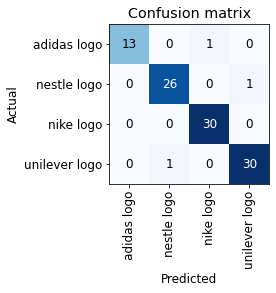

In [96]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

# Exporting model (export.pkl)

In [97]:
learn.export()

check if model in path()

In [98]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

# Importing model (export.pkl)

In [99]:
learn_inf = load_learner(path/'export.pkl', cpu=True)

create widgets

In [100]:
btn_upload = widgets.FileUpload()
out_pl = widgets.Output()
lbl_pred = widgets.Label()

Call model on uploaded image

In [101]:
def on_data_change(change):
    lbl_pred.value = ''
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

In [102]:
btn_upload.observe(on_data_change, names=['data'])

In [110]:
display(VBox([widgets.Label('Select your brand!'), btn_upload, out_pl, lbl_pred]))